In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
import unicodedata
import re
import numpy as np
import os
import io
import time

In [ ]:
#西班牙文翻英文
#資料來源http://www.manythings.org/anki/

path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"

In [ ]:
#資料前處理：
# 將每個句子增加開始與結束標記
# 刪除特殊符號
# 建立單詞索引
# 將句子進行填充

def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    w = w.rstrip().strip()
    w = '<start> ' + w + ' <end>' #開始與結束
    return w

In [ ]:
en_sentence = u"May I borrow this book?"
sp_sentence = u"¿Puedo tomar prestado este libro?"
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(sp_sentence).encode('utf-8'))

<start> may i borrow this book ? <end>
b'<start> \xc2\xbf puedo tomar prestado este libro ? <end>'


In [ ]:
# 清除重音
# 清理句子
# 整理回傳的句子
def create_dataset(path, num_examples):
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]

    return zip(*word_pairs)

In [ ]:
en, sp = create_dataset(path_to_file, None)
print(en[-1])
print(sp[-1])

<start> if you want to sound like a native speaker , you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo . <end>
<start> si quieres sonar como un hablante nativo , debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un musico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado . <end>


In [ ]:
def max_length(tensor):
    return max(len(t) for t in tensor)

In [ ]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  lang_tokenizer.fit_on_texts(lang)
  tensor = lang_tokenizer.texts_to_sequences(lang)
  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')
  return tensor, lang_tokenizer

In [ ]:
def load_dataset(path, num_examples=None):
    # 建立輸入與預測對象
    targ_lang, inp_lang = create_dataset(path, num_examples)

    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [ ]:
# 將數據大小控制在30000筆
num_examples = 30000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor) #計算最大長度的張量

In [ ]:
# 拆分80%訓練、20%測試
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# 確認長度
len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val)

(24000, 24000, 6000, 6000)

In [ ]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

In [ ]:
print ("輸入; 文字索引")
convert(inp_lang, input_tensor_train[0])
print ()
print ("目標; 文字索引")
convert(targ_lang, target_tensor_train[0])

輸入; 文字索引
1 ----> <start>
23 ----> te
428 ----> encontre
3 ----> .
2 ----> <end>

目標; 文字索引
1 ----> <start>
4 ----> i
331 ----> found
6 ----> you
3 ----> .
2 ----> <end>


In [ ]:
len(input_tensor_train)

24000

In [ ]:
#透過tf.data，將input_tensor_train與target_tensor_train做資料整理，以提升運算效率
BUFFER_SIZE = len(input_tensor_train)
#依據input_tensor_train筆數建立BUFFER，進行shuffle
BATCH_SIZE = 64
#取整數作為每一次epoch的steps
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE 
embedding_dim = 256
#GRU的單元數
units = 1024
#預測內容是西班牙文，預測目標是英文
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
input_tensor_train

array([[   1,   23,  428, ...,    0,    0,    0],
       [   1,   54, 3123, ...,    0,    0,    0],
       [   1,    4,    8, ...,    0,    0,    0],
       ...,
       [   1,    9,   17, ...,    0,    0,    0],
       [   1, 3028,   32, ...,    0,    0,    0],
       [   1,   54,  345, ...,    0,    0,    0]], dtype=int32)

In [ ]:
next(iter(dataset))

(<tf.Tensor: shape=(64, 16), dtype=int32, numpy=
 array([[   1, 1810,   21, ...,    0,    0,    0],
        [   1,  100,   53, ...,    0,    0,    0],
        [   1,   28,    7, ...,    0,    0,    0],
        ...,
        [   1,   26,  142, ...,    0,    0,    0],
        [   1,  489,  273, ...,    0,    0,    0],
        [   1,   53,  647, ...,    0,    0,    0]], dtype=int32)>,
 <tf.Tensor: shape=(64, 11), dtype=int32, numpy=
 array([[   1,    4,   76,    9,  146,  595,    3,    2,    0,    0,    0],
        [   1,    4,  103,   47,   15,   36,    3,    2,    0,    0,    0],
        [   1,   20,   90,   12,  601,    3,    2,    0,    0,    0,    0],
        [   1,  280,   31,  765,    3,    2,    0,    0,    0,    0,    0],
        [   1, 1048, 1100,    3,    2,    0,    0,    0,    0,    0,    0],
        [   1,    4,   18,   34,  129,    3,    2,    0,    0,    0,    0],
        [   1,   10,  361,   21,  189,    3,    2,    0,    0,    0,    0],
        [   1,   10,   11, 1231,   

In [ ]:
#生成迭代器觀察內容與目標
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 16]), TensorShape([64, 11]))

In [ ]:
example_target_batch

<tf.Tensor: shape=(64, 11), dtype=int32, numpy=
array([[   1,   10,   11,  412,    3,    2,    0,    0,    0,    0,    0],
       [   1,  255,   17,   31, 1259,    3,    2,    0,    0,    0,    0],
       [   1,   32,    9,  625, 1864,   37,    2,    0,    0,    0,    0],
       [   1,   14,   51,    9, 2589,  449,    3,    2,    0,    0,    0],
       [   1,    4,   26, 2619,    3,    2,    0,    0,    0,    0,    0],
       [   1,  124,   31,  312,   43,    7,    2,    0,    0,    0,    0],
       [   1,    8,   57,  365,  662,    7,    2,    0,    0,    0,    0],
       [   1,    8,   19, 2398, 3097,    7,    2,    0,    0,    0,    0],
       [   1,    4, 1132,   19, 3047,    3,    2,    0,    0,    0,    0],
       [   1,   20,  168,  137,  186,    3,    2,    0,    0,    0,    0],
       [   1,  279,   15,    5,    3,    2,    0,    0,    0,    0,    0],
       [   1,   10,   11,   31,  209,  803,    3,    2,    0,    0,    0],
       [   1,    4,   18,    9, 2624,    3,    2,   

In [ ]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz #BATCH_SIZE
    self.enc_units = enc_units #單元數
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim) #每一個單詞轉為Embedding
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform') #均勻初始化

  def call(self, x, hidden): #做一層embedding+GRU
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden) #每一次初始化為Hidden的變數
    return output, state

  def initialize_hidden_state(self): #建立空的初始化
    return tf.zeros((self.batch_sz, self.enc_units))

In [ ]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE) #依據vocab_inp_size、embedding_dim、單元數、BATCH_SIZE建立Encoder

# 輸入的樣本
sample_hidden = encoder.initialize_hidden_state() #依據Batch_sz與enc_units初始化
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden) #觀察一下預測內容與具備GRU單元數的隱藏層樣態
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape)) #sample_output（批次大小、訓練資料長度、單元數）
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape)) #sample_hidden（批次大小、單元數）

Encoder output shape: (batch size, sequence length, units) (64, 16, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [ ]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__() #繼承TF的BahdanauAttention
    self.W1 = tf.keras.layers.Dense(units) #依據GRU的單元數進行Dense
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # 執行加法計算分數，先將讓query多一個維度，相加之後做一個tanh，獲得分數，score = FC(tanh(FC(EO) + FC(H)))
    hidden_with_time_axis = tf.expand_dims(query, 1)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))
    # attention weights = softmax(score, axis = 1) 
    attention_weights = tf.nn.softmax(score, axis=1) 
    # context_vector = sum(attention weights * EO, axis = 1)
    context_vector = attention_weights * values 
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
attention_layer = BahdanauAttention(10) #Attention的強度
attention_result, attention_weights = attention_layer(sample_hidden, sample_output) #將初始化空的sample_hidden與要進行預測內容

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 16, 1)


In [ ]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz): #詞彙、embedding維度、單元數、批次大小
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size) 
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # 透過BahdanauAttention建立context_vector、attention_weights
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # 做一次embedding
    x = self.embedding(x)

    # x整合後的大小batch_size、embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # 將x給GRU計算後回報結果與狀態
    output, state = self.gru(x)

    # 資料維度整理
    output = tf.reshape(output, (-1, output.shape[2]))

    # 做線性轉換後輸出
    x = self.fc(output)

    return x, state, attention_weights

In [ ]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE) #依據詞彙、embedding維度、單元數、批次大小進行Decoder

sample_decoder_output, _, _ = decoder(tf.random.uniform((64, 1)), #隨機產生批次大小的資料作為起始值、sample_hidden初始值、預測內容
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 4935)


In [ ]:
#定義優化器、衡量標準
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0)) #將數字轉換為邏輯值
  loss_ = loss_object(real, pred) #透過loss_object做Crossentropy計算
  #透過tf.cast做函數轉換，如：1轉True
  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [ ]:
#記錄每一次計算的Checkpoints
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [ ]:
@tf.function #加上tf.function修飾器
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    #通過編碼器傳遞輸入，編碼器產生「編碼器輸出」和「編碼器隱藏狀態」。
    enc_output, enc_hidden = encoder(inp, enc_hidden)
    #將「編碼器隱藏狀態」傳給「解碼器的隱藏狀態」
    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # 將預測結果作為下一個輸入
    for t in range(1, targ.shape[1]):
      # 解碼器返回「預測值」和「解碼器隱藏狀態」。
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
      # 將答案與predictions做Loss計算
      loss += loss_function(targ[:, t], predictions)

      # 將預測目標，作為下一個解碼器dec_input的輸入
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))
  
  variables = encoder.trainable_variables + decoder.trainable_variables
  #紀錄每一次的自動微分結果
  gradients = tape.gradient(loss, variables)
  #進行優化器計算
  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [ ]:
#開始訓練模型
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0
  #將預測內容、預測目標放入
  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
        print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                     batch,
                                                     batch_loss.numpy()))
  # 每兩個epochs就儲存一次checkpoint
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.6868
Epoch 1 Batch 100 Loss 2.1530
Epoch 1 Batch 200 Loss 1.7936
Epoch 1 Batch 300 Loss 1.6646
Epoch 1 Loss 2.0365
Time taken for 1 epoch 42.73405861854553 sec

Epoch 2 Batch 0 Loss 1.5754
Epoch 2 Batch 100 Loss 1.4577
Epoch 2 Batch 200 Loss 1.3582
Epoch 2 Batch 300 Loss 1.2172
Epoch 2 Loss 1.3887
Time taken for 1 epoch 33.29595971107483 sec

Epoch 3 Batch 0 Loss 1.0997
Epoch 3 Batch 100 Loss 0.9315
Epoch 3 Batch 200 Loss 0.9037
Epoch 3 Batch 300 Loss 0.8976
Epoch 3 Loss 0.9723
Time taken for 1 epoch 32.43663215637207 sec

Epoch 4 Batch 0 Loss 0.7002
Epoch 4 Batch 100 Loss 0.6771
Epoch 4 Batch 200 Loss 0.5618
Epoch 4 Batch 300 Loss 0.6263
Epoch 4 Loss 0.6640
Time taken for 1 epoch 33.00522756576538 sec

Epoch 5 Batch 0 Loss 0.4257
Epoch 5 Batch 100 Loss 0.3978
Epoch 5 Batch 200 Loss 0.5117
Epoch 5 Batch 300 Loss 0.4234
Epoch 5 Loss 0.4544
Time taken for 1 epoch 32.55444025993347 sec

Epoch 6 Batch 0 Loss 0.2512
Epoch 6 Batch 100 Loss 0.4008
Epoch 6 Batch 200 Loss

In [ ]:
#驗證與產生結果
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp)) #建立最大的輸入與預測目標
    #將資料做前處理，如去除符號、轉tensor..等
    sentence = preprocess_sentence(sentence) 
    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=max_length_inp,
                                                           padding='post')    
    inputs = tf.convert_to_tensor(inputs)
    result = ''

    hidden = [tf.zeros((1, units))]
    #透過encoder產生出輸出與狀態
    enc_out, enc_hidden = encoder(inputs, hidden)
    #編碼層的狀態一樣給解碼層(dec_hidden)
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
        # 透過decoder解碼，獲得預測結果、解碼狀態、注意力權重
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # 儲存注意力權重
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()
        # 將預測ID回饋到模型
        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.index_word[predicted_id] + ' '
        
        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

       
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [ ]:
# 繪製注意力視覺化
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    plt.show()

In [ ]:
# 將模型用來做結果預測
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

Input: <start> hace mucho frio aqui . <end>
Predicted translation: it s very cold here . <end> 


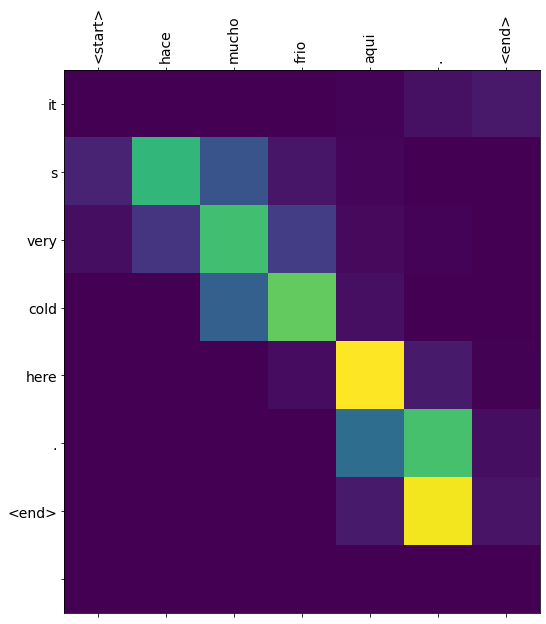

In [ ]:
translate(u'hace mucho frio aqui.')

Input: <start> trata de averiguarlo . <end>
Predicted translation: try to figure it out . <end> 


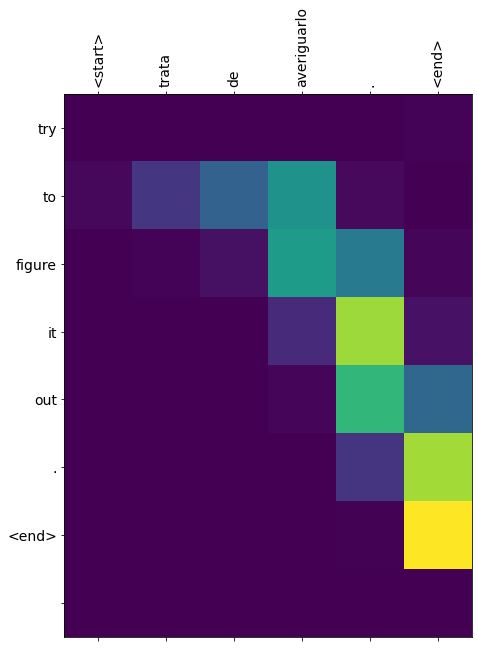

In [ ]:
translate(u'trata de averiguarlo.')